# Exploratory Data Analysis (EDA)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats # statistics module
import matplotlib.gridspec as gridspec 
from sklearn.feature_selection import mutual_info_regression # MI score


In [2]:
# loading data (both train and test data)
raw_data = pd.read_csv("/work/ames_housing_dataset/train.csv")

In [3]:
# configs
#sns.set(rc={'figure.figsize':(24,16)}) # sets the standard figsize for seaborn

# maybe these are needed later:
pd.set_option('display.max_columns', None) # sets no cap on how many columns are shown 
pd.set_option('display.max_rows', None)  # # sets no cap on how many rows are shown
pd.set_option('display.max_colwidth', None) # Removes the maximum width in characters of a column in the repr of a pandas data structure.

# Set Matplotlib defaults settings
#plt.style.use("seaborn-whitegrid")
#plt.rc("figure", autolayout=True)
#plt.rc(
#    "axes",
#    labelweight="bold",
#    labelsize="large",
#    titleweight="bold",
#    titlesize=14,
#    titlepad=10,
#)

## Information about SalePrice

First thing first, we need to get some information about the target value; SalePrice:

In [4]:
raw_data.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

what are the price range? and what is the distribution of the prices?

In [5]:
print(f"The cheapest house was sold for ${raw_data.SalePrice.min()}",
"and the most expensive house was sold for ${raw_data.SalePrice.max()}")

The cheapest house was sold for $34900 and the most expensive house was sold for ${raw_data.SalePrice.max()}


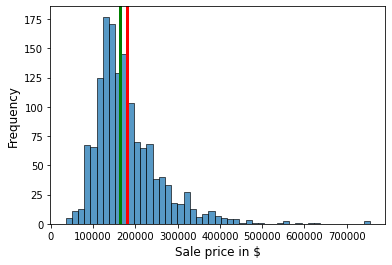

In [6]:
sns.histplot(raw_data.SalePrice)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("Sale price in $", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.axvline(x = raw_data.SalePrice.mean(), c = 'red', linewidth=3)
plt.axvline(x = raw_data.SalePrice.median(), c = 'green', linewidth=3)
plt.tight_layout


plt.savefig(fname="graphs/sale_price_histogram", transparent=True) # saves the figure to the file explore

In [7]:
numeric_columns = raw_data.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64']).columns
string_columns = raw_data.select_dtypes(include=['object']).columns

quantitative_count = len(numeric_columns)
qualitative_count = len(string_columns)

print(f"quantitative count: {quantitative_count} and qualitative count: {qualitative_count}")

# 38 quantitative with the ID column, and ofc 37 without

quantitative count: 38 and qualitative count: 43


The oldest house was built in 1872 and the newest house was built in 2010


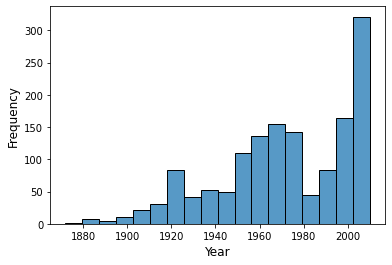

In [8]:
sns.histplot(raw_data.YearBuilt)
#plt.title("Distribution of house age", fontsize=22)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.tight_layout
print(f"The oldest house was built in {raw_data.YearBuilt.min()} "+
f"and the newest house was built in {raw_data.YearBuilt.max()}")

plt.savefig(fname="graphs/house_age_histogram", transparent=True) # saves the figure to the file explore

We can investigate when the houses where sold by grouping the entries by these features, and plotting them in a histogram

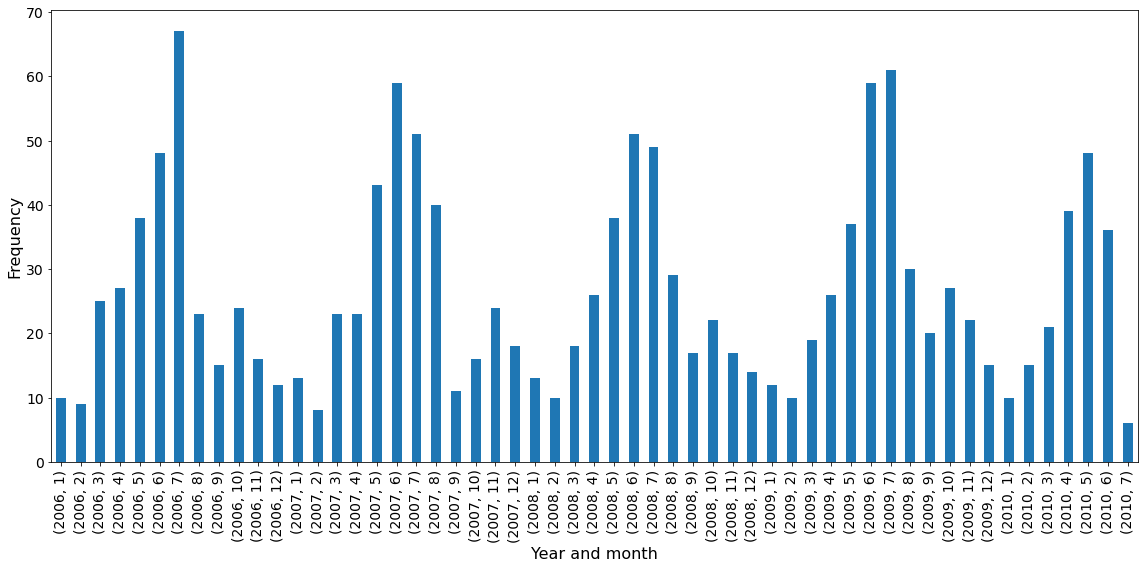

In [9]:
lf = 16
tf =14

plt.figure(figsize=(16, 8))
raw_data.groupby(['YrSold', 'MoSold']).Id.count().plot(kind='bar')
#plt.title("Distribution of when houses where sold")
plt.xlabel("Year and month", fontsize=lf)
plt.ylabel("Frequency", fontsize=lf)
plt.xticks(fontsize=tf)
plt.yticks(fontsize=tf)
plt.tight_layout()
plt.savefig(fname="graphs/month_sold_distribution", transparent=True) # saves the figure to the file explore

We see strongly seasonale pattern in the plot above, with peaks in June and July.

Next we look at the distribution of where the houses are located:

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

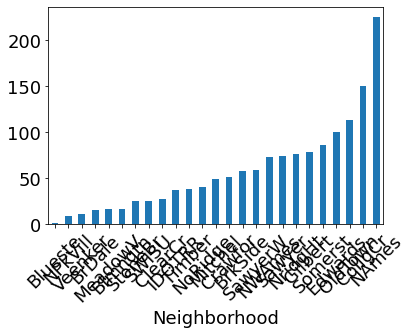

In [10]:
raw_data.groupby('Neighborhood').Id.count().sort_values().plot(kind='bar')
plt.xlabel("Neighborhood",fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18, rotation=45)
plt.tight_layout

In [11]:
def feature_type_segmentation(df):
    """ Returns a list of numerical and string features,
    excluding SalePrice and Id. Returns first numerical features, then string features"""
    
    # Numerical Features
    num_features = df.select_dtypes(include=['int64','float64']).columns
    num_features = num_features.drop(['Id','SalePrice']) # drop ID and SalePrice

    # Categorical Features
    cat_features = df.select_dtypes(include=['object']).columns
    
    return list(num_features), list(cat_features)

num_features, cat_features = feature_type_segmentation(raw_data)

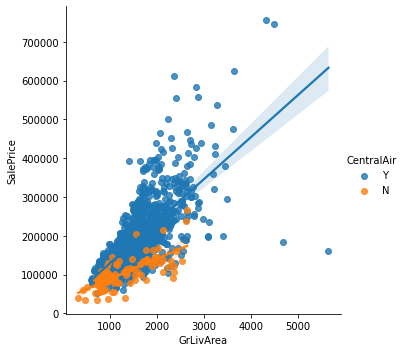

In [12]:
sns.lmplot(x="GrLivArea", y="SalePrice", hue="CentralAir", data=raw_data)

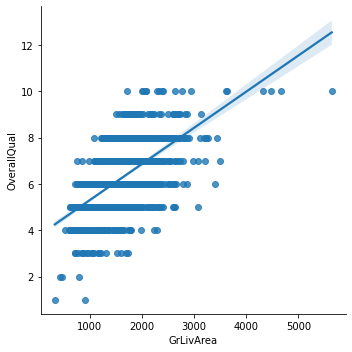

In [13]:
sns.lmplot(x="GrLivArea", y="OverallQual", data=raw_data)

## Mapping the houses

### Folium Map (interactive)

links:
https://www.tmwr.org/ames.html
https://rstudio-pubs-static.s3.amazonaws.com/337439_24918eaefe724411be93e41ede48b256.html
https://cran.r-project.org/web/packages/AmesHousing/AmesHousing.pdf
Source for geocodes: https://github.com/topepo/AmesHousing 

In [14]:
# maybe needs to be run before importing the libraries below
!pip install rdata 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 845.2/845.2 KB 12.8 MB/s eta 0:00:00
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [15]:
import rdata # used to parce R (.rda files) data to python
import folium # interactive geocode visualising module
from folium import plugins

In [16]:
# parses the geocodes from the R-file ames_geo.rda to a python dictionary 
# and then converts it to a pandas dataframe

parsed = rdata.parser.parse_file("ames_geo.rda")
converted = rdata.conversion.convert(parsed)
converted_dataframe = converted['ames_geo']
ames_coordinates = converted_dataframe.copy()

/root/venv/lib/python3.7/site-packages/rdata/conversion/_conversion.py:674: UserWarning: Missing constructor for R class "tbl_df". The constructor for class "tbl" will be used instead.
  stacklevel=1,
/root/venv/lib/python3.7/site-packages/rdata/conversion/_conversion.py:674: UserWarning: Missing constructor for R class "tbl". The constructor for class "data.frame" will be used instead.
  stacklevel=1,


In [17]:
parsed1 = rdata.parser.parse_file("ames_raw.rda")
converted1 = rdata.conversion.convert(parsed1)
converted_dataframe1 = converted1['ames_raw']

/root/venv/lib/python3.7/site-packages/rdata/conversion/_conversion.py:674: UserWarning: Missing constructor for R class "collector_integer". The constructor for class "collector" will be used instead.
  stacklevel=1,
/root/venv/lib/python3.7/site-packages/rdata/conversion/_conversion.py:674: UserWarning: Missing constructor for R class "collector". The underlying R object is returned instead.
  stacklevel=1,
/root/venv/lib/python3.7/site-packages/rdata/conversion/_conversion.py:674: UserWarning: Missing constructor for R class "collector_character". The constructor for class "collector" will be used instead.
  stacklevel=1,
/root/venv/lib/python3.7/site-packages/rdata/conversion/_conversion.py:674: UserWarning: Missing constructor for R class "collector_guess". The constructor for class "collector" will be used instead.
  stacklevel=1,
/root/venv/lib/python3.7/site-packages/rdata/conversion/_conversion.py:674: UserWarning: Missing constructor for R class "col_spec". The underlying R o

In [18]:
map_df = converted_dataframe1[['PID', 'Neighborhood']]
map_df = pd.merge(map_df, ames_coordinates, on="PID") 

In [19]:
# switch funktion
def switch(x):
    return {
        'NAmes': 'green',
        'Gilbert':'yellow',
        'StoneBr':'blue',
        'NWAmes':'red',
        'Somerst':'orange',
        'BrDale':'purple',
        'NPkVill':'darkred',
        'NridgHt':'lightred',
        'Blmngtn':'beige',
        'NoRidge':'darkblue',
        'SawyerW':'darkgreen',
        'Sawyer':'',
        'Greens':'cadetblue',
        'BrkSide':'darkpurple',
        'OldTown':'white',
        'IDOTRR':'pink',
        'ClearCr':'lightblue',
        'SWISU':'lightgreen',
        'Edwards':'gray',
        'CollgCr':'black',
        'Crawfor':'lightgray',

        # nedenstånde er gentaget farver:
        'Blueste':'green',
        'Mitchel':'blue',
        'Timber':'yellow',
        'MeadowV':'red',
        'Veenker':'purple',
        'Landmrk':'orange',
        'GrnHill':'lightgreen',
    }[x]

In [20]:
ames_city_coordinates = [42.02636598826907, -93.64648116561449]

map = folium.Map(location=ames_city_coordinates, zoom_start=12, tiles='cartodbpositron', control_scale=True)

# questionable whether we need the map or not
minimap = plugins.MiniMap(toggle_display=True)
map.add_child(minimap)

plugins.Fullscreen(position='topright').add_to(map)
plugins.MousePosition(position='topleft').add_to(map)

for ind in map_df.index:
    folium.Circle(
            radius=1,
            location=[map_df['Latitude'][ind], map_df['Longitude'][ind]],
            color=switch(map_df['Neighborhood'][ind]),
            fill=True,
        ).add_to(map)

folium.TileLayer('cartodbpositron').add_to(map)
folium.TileLayer('stamentoner').add_to(map)
folium.TileLayer('openstreetmap').add_to(map)

folium.LayerControl().add_to(map)

map

In [21]:
map.save("ames_map.html") # saves the map

### Static map

links:
[A advanced tutorial](https://rosenfelder.ai/create-maps-with-python/) ([and its github](https://github.com/InformationSystemsFreiburg/map_creation_amsterdam_python))


In [22]:
#!pip install Fiona
#!pip install Rtree
#!pip install Shapely

In [23]:
#import geopandas as gpd

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a79dfa2f-1b6b-4b40-b0ca-7dec9e2a123f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>